Imports

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [23]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

print(data_dir)

C:\Users\PC\.keras\datasets\flower_photos_extracted


C:\Users\PC\.keras\datasets\flower_photos_extracted\flower_photos
[WindowsPath('C:/Users/PC/.keras/datasets/flower_photos_extracted/flower_photos/daisy/100080576_f52e8ee070_n.jpg'), WindowsPath('C:/Users/PC/.keras/datasets/flower_photos_extracted/flower_photos/daisy/10140303196_b88d3d6cec.jpg'), WindowsPath('C:/Users/PC/.keras/datasets/flower_photos_extracted/flower_photos/daisy/10172379554_b296050f82_n.jpg'), WindowsPath('C:/Users/PC/.keras/datasets/flower_photos_extracted/flower_photos/daisy/10172567486_2748826a8b.jpg'), WindowsPath('C:/Users/PC/.keras/datasets/flower_photos_extracted/flower_photos/daisy/10172636503_21bededa75_n.jpg'), WindowsPath('C:/Users/PC/.keras/datasets/flower_photos_extracted/flower_photos/daisy/102841525_bd6628ae3c.jpg'), WindowsPath('C:/Users/PC/.keras/datasets/flower_photos_extracted/flower_photos/daisy/1031799732_e7f4008c03.jpg'), WindowsPath('C:/Users/PC/.keras/datasets/flower_photos_extracted/flower_photos/daisy/10391248763_1d16681106_n.jpg'), WindowsPat

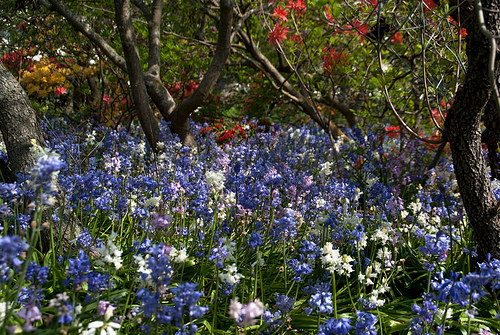

In [24]:


data_dir = data_dir / 'flower_photos'
image_count = len(list(data_dir.glob('*/*.jpg')))

print(data_dir)
print(list(data_dir.glob('*/*.jpg')))
print(image_count)

#roses = list(data_dir.glob('roses/*'))
#PIL.Image.open(str(roses[0]))
#PIL.Image.open(str(roses[1]))


tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[1]))

#PIL.Image.open(str(tulips[0]))


In [25]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
